In [127]:
# install your library

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
import random

In [128]:
path = "C:/Users/zjy97/Downloads/python-causality-handbook-v1.0/matheusfacure-python-causality-handbook-f666303/causal-inference-for-the-brave-and-true/data/"

In [182]:
# 1. how to control what you cannot see
# like ps, psm, linear regression, matching are very good at controlling confounding in non-random data, but they are based
# on a key assumption: conditional unconfoundedness, that means all confounders are known and measured, but this is rarely possible
# one way to solve it is using instruments, but instruments are hard to control

# 2. explain what is fixed effect
# we have two vars, marries and lwage on multiple individuals for multiple years
from linearmodels.datasets import wage_panel
data = wage_panel.load()
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]# the coef of each year

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


In [185]:
# we need to remove ethnicity dummies, black and hisp, they are constant for the individual, also we need to remove
# education and occupation, since this is probably mediating the effect of marriage on wage
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

# this is for each individual, we find the mean stats
mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

# then we demean the data
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


In [186]:
# after demeaning the data, we can run our fixed effect model
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]#ate is 0.11, with small p value that means statistically significant

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.714e-17,0.005,-1.91e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


In [187]:
# 3. we also can directly call PanelOLS for fixed effect ols
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


In [188]:
# run a simple ols to see, simple ols doesnt take the time structure of the data into account, it has bigger std
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


In [ ]:
# 4. to summarize the steps of fixed effect panel ols
# first group by individual, compute the mean values of X columns and Y, X columns contain the confounders and treatment!,not just confounders
# in panel data, all data minus the mean values
# then run regression on the demeaned data

# you also can direclt run PanelOLS

In [191]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))# you need to define your panel, nr is the individual and every nr has many years of data

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


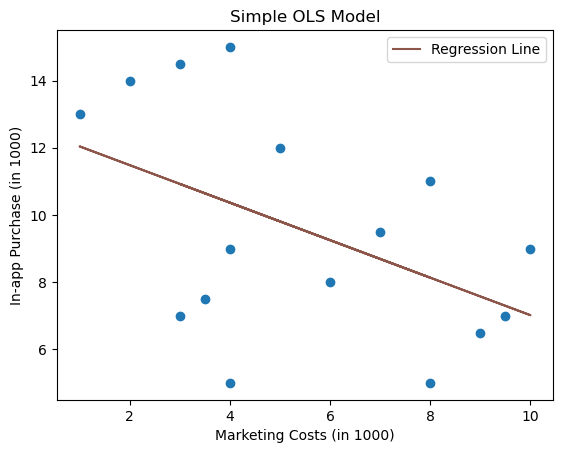

In [192]:
# 5. visualizing to compare fixed effect model and simple ols
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

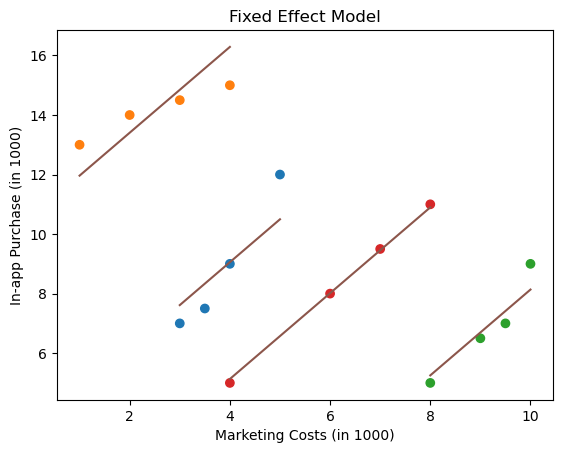

In [193]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

In [194]:
# 6. do you find the time effect havent been considered?

# add a parameter that cluster_time = True
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
# cluster_time doesnt treat every individual equally but treat 
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


In [ ]:
# 7. when panel data wont help you

# issue 1
# when you dont have random data nor good instruments, the fixed effect could be convincing
# but if your confounders are changing in time, fixed effects can only eliminates bias from attributes, and you cannot solve it by
# directly adding a cluster_time = True because clustering at the time level can help control for ubonserved factors that
# change over time and affect all individuals equally but may be not fully accouting for the individual specific time varying confounders


# issue 2
# reversed causality, fixed effects wouldnt be able to control some causations that can be reversed


# 8. what should pay attention
# pay attention to feature selection, shouldnt pick those features that never been changed like sex
# shouldnt pick those features would weaken or stronger the impact of your treatment